In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import matplotlib.cm as cm

cols = [cm.tab10(i) for i in range(10)]
cols.append(cm.Set2(5))
cols.append(cm.Paired(4))

In [2]:
dat = pd.read_pickle('COPROseq_absolute_abundance.pkl')
dat

,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,5.151164e+07
1,B. cellulosilyticus WH2,LF0,1,7.110996e+07
2,B. ovatus,LF0,1,8.427954e+07
3,B. thetaiotaomicron,LF0,1,3.218013e+07
4,B. uniformis,LF0,1,7.739366e+06
...,...,...,...,...
4495,C. scindens,HF0,42,4.633884e+07
4496,C. spiroforme,HF0,42,8.481661e+05
4497,D. longicatena,HF0,42,3.302648e+04
4498,P. distasonis,HF0,42,3.108796e+07


In [3]:
LF0 = dat[dat['Treatment'] == 'LF0'].copy()
HF0 = dat[dat['Treatment'] == 'HF0'].copy()

In [135]:
strain = LF0.Strain.unique()
# x0 = np.array([LF0[LF0['Day'] == 1].groupby('Strain')['Absolute_abundance'].mean()[i] for i in strain])
x0 = np.ones(len(strain))*10
# t_span = [0, 42]
# t_eval = np.linspace(t_span[0], t_span[-1], 25)
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[-1], 1000)

def define_random_params(n=len(strain)):
    p = Parameters()
    p.add('species', value=n, vary=False)
    for i in range(n):
        # p.add(f'growth_{i+1}', value=np.random.uniform(0, 10), min=0, vary=True)
        p.add(f'growth_{i+1}', value=np.random.normal(15, 2), min=0, vary=True)
        # p.add(f'susceptibility_{i+1}', value=np.random.uniform(-0.5, 0.5), vary=True)
        p.add(f'susceptibility_{i+1}', value=0, vary=False)
        for j in range(n):
            if i == j:
                # p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-0.1, 0), max=0, vary=True)
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-0.05, 0), max=0, vary=True)
            else:
                # p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-0.8, 2), vary=True)
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-1, 1), vary=True)
    return p

params = define_random_params()

In [136]:
def gLV(x, t, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for j in range(params['species'].value)] for i in range(params['species'].value)])
    susceptibility = np.array([params[f'susceptibility_{i+1}'].value for i in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])
    C = 0 if (t <= 12 or t >= 25) else 1

    return np.array([x[i]*(growth[i] + inter + C*susceptibility[i]) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span, x0=x0, params=params, t_eval=t_eval):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [137]:
sol = solve_gLV()
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3734
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029029 ,   3.003003  ,   3.1031031 ,
         3.2032032 ,   3.3033033 ,   3.4034034 ,   3.5035035 ,
         3.6036036 ,   3.7037037 ,   3.8038038 ,   3.9039039 ,
         4.004004  ,   4.1041041 ,   4.2042042 ,   4.3043043 ,
         4.4044044 ,   4.5045045 ,   4.6046046 ,   4.7047047 ,
         4.8048048 ,   4.9049049 ,   5.00500501,   5.10510511,
 

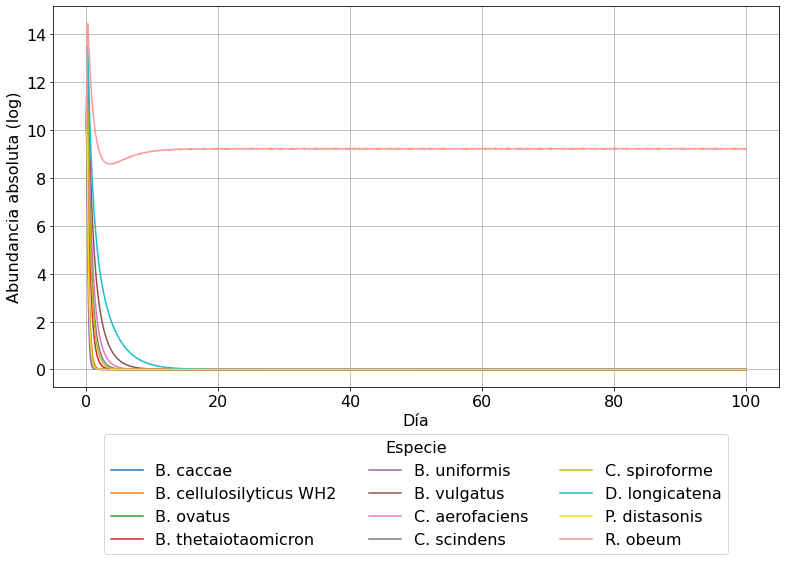

In [138]:
plt.figure(figsize=(13, 7))
for i in range(len(strain)):
    plt.plot(sol.t, sol.y[i], color=cols[i], label=strain[i])
# plt.yscale('log')
plt.xlabel('Día')
plt.ylabel('Abundancia absoluta (log)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.46),
          ncol=3, fancybox=True, shadow=False, title='Especie')
plt.grid()
plt.show()

In [13]:
test_data = sol.y + np.random.normal(size=sol.y.shape)*1
test_t = sol.t

In [14]:
result = fit_gLV(test_data, test_t)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2209
    # data points      = 300
    # variables        = 168
    chi-square         = 317.169030
    reduced chi-square = 2.40279568
    Akaike info crit   = 352.695712
    Bayesian info crit = 974.931168
##  Warning: uncertainties could not be estimated:
    susceptibility_1:   at initial value
    susceptibility_2:   at initial value
    susceptibility_3:   at initial value
    susceptibility_4:   at initial value
    susceptibility_5:   at initial value
    susceptibility_6:   at initial value
    susceptibility_7:   at initial value
    susceptibility_10:  at initial value
    susceptibility_11:  at initial value
    susceptibility_12:  at initial value
[[Variables]]
    species:            12 (fixed)
    growth_1:           3.06809835 (init = 3.071422)
    susceptibility_1:   5.00000000 (init = 5)
    cross_int_1_1:     -3.65460957 (init = -3.426895)
    cross_int_1_2:      2.26111584 (init = 2.235205)


In [15]:
final = test_data + result.residual.reshape(test_data.shape)

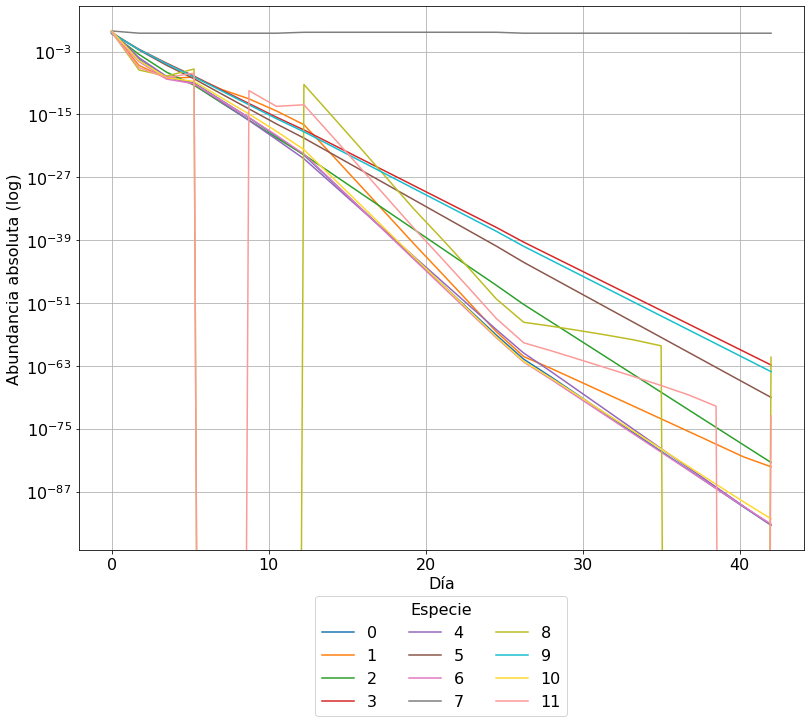

In [21]:
plt.figure(figsize=(13, 10))
for i in range(len(strain)):
    plt.plot(sol.t, sol.y[i], color=cols[i], label=strain[i])
    # plt.plot(sol.t, test_data[i], color=cols[i])
    # plt.plot(sol.t, final[i], linestyle='--', color=cols[i])
plt.yscale('log')
plt.xlabel('Día')
plt.ylabel('Abundancia absoluta (log)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=3, fancybox=True, shadow=False, title='Especie')
plt.grid()
plt.show()

***
# Implementing perturbation term

In [16]:
strain = LF0.Strain.unique()
x0 = np.array([LF0[LF0['Day'] == 1].groupby('Strain')['Absolute_abundance'].mean()[i] for i in strain])
x = np.array([LF0[LF0['Strain'] == i]['Absolute_abundance'].values for i in strain])
t = np.array([LF0[LF0['Strain'] == i]['Day'].values for i in strain])
t_span = [LF0.Day.values.min(), LF0.Day.values.max()]
t_eval = LF0.Day.unique()

def define_random_params(n=len(x)):
    p = Parameters()
    p.add('species', value=n, vary=False)
    for i in range(n):
        p.add(f'growth_{i+1}', value=np.random.uniform(0, 10), min=0, vary=True)
        p.add(f'susceptibility_{i+1}', value=np.random.uniform(5, 5), vary=True)
        for j in range(n):
            if i == j:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 0), max=0, vary=True)
            else:
                p.add(f'cross_int_{i+1}_{j+1}', value=np.random.uniform(-5, 5), vary=True)
    return p

params = define_random_params()

In [17]:
def gLV(x, t, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for j in range(params['species'].value)] for i in range(params['species'].value)])
    susceptibility = np.array([params[f'susceptibility_{i+1}'].value for i in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])
    C = 0 if (t <= 12 or t >= 25) else 1

    return np.array([x[i]*(growth[i] + inter + C*susceptibility[i]) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span, x0=x0, params=params, t_eval=t_eval):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [18]:
result = fit_gLV(data=x, t=t, params=params)
final = x + result.residual.reshape(x.shape)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 2100
    # variables        = 168
    chi-square         = 4.8537e+20
    reduced chi-square = 2.5123e+17
    Akaike info crit   = 84297.6686
    Bayesian info crit = 85246.8169
##  Warning: uncertainties could not be estimated:
    growth_1:           at initial value
    susceptibility_1:   at initial value
    cross_int_1_1:      at initial value
    cross_int_1_2:      at initial value
    cross_int_1_3:      at initial value
    cross_int_1_4:      at initial value
    cross_int_1_5:      at initial value
    cross_int_1_6:      at initial value
    cross_int_1_7:      at initial value
    cross_int_1_8:      at initial value
    cross_int_1_9:      at initial value
    cross_int_1_10:     at initial value
    cross_int_1_11:     at initial value
    cross_int_1_12:     at initial value
    growth_2:           at initial value
    susceptibility_2:   at initial value
    cross

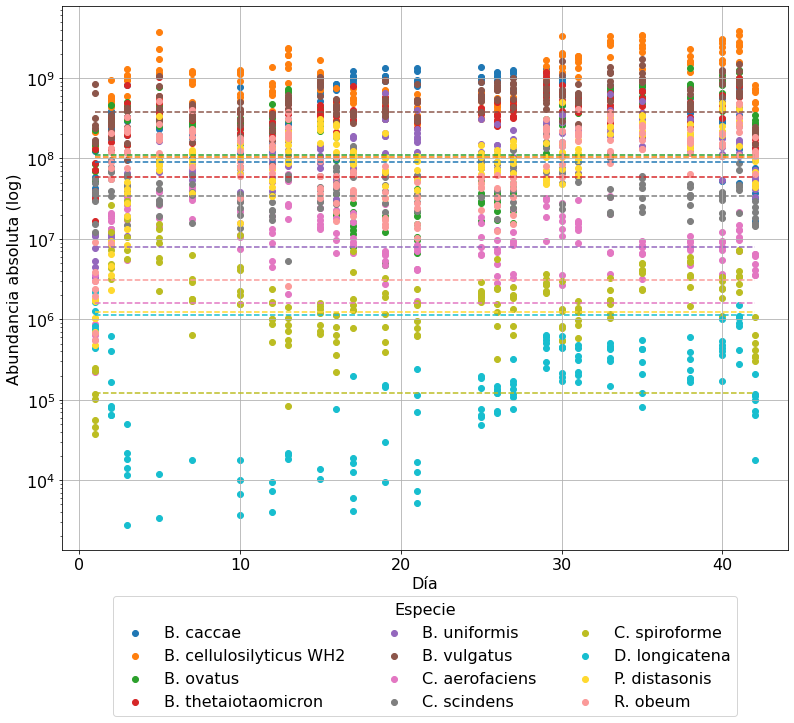

In [19]:
plt.figure(figsize=(13, 10))
for i in range(len(strain)):
    plt.scatter(t[i], x[i], label=strain[i], color=cols[i])
    plt.plot(t[i], final[i], linestyle='--', color=cols[i])
plt.yscale('log')
plt.xlabel('Día')
plt.ylabel('Abundancia absoluta (log)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=3, fancybox=True, shadow=False, title='Especie')
plt.grid()
plt.show()